In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch import nn
from simulators import SimulatorBlob

In [3]:
NPIX = 32
bounds = None

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817727684/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


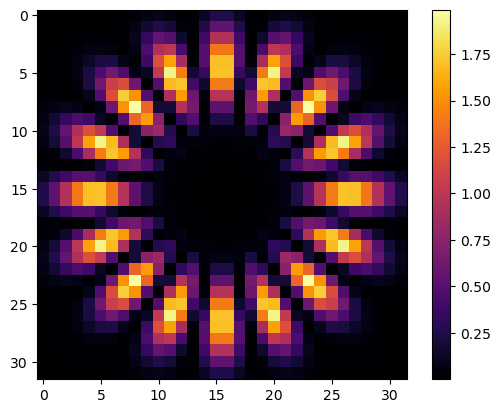

In [4]:
def gen_target_image(Npix):
    l = torch.linspace(-1, 1, Npix)
    L1, L2 = torch.meshgrid(l, l)
    R = (L1**2+L2**2)**0.5
    t = torch.exp(-(R-0.7)**2/2/0.15**2)
    t *= torch.cos(torch.arctan2(L1, L2)*16)+1
    return t

z0 = gen_target_image(Npix = NPIX)
torch.save(z0, 'task2_target_image.pt')
z0 = torch.load("task2_target_image.pt")
plt.imshow(z0, cmap = 'inferno')
plt.colorbar()

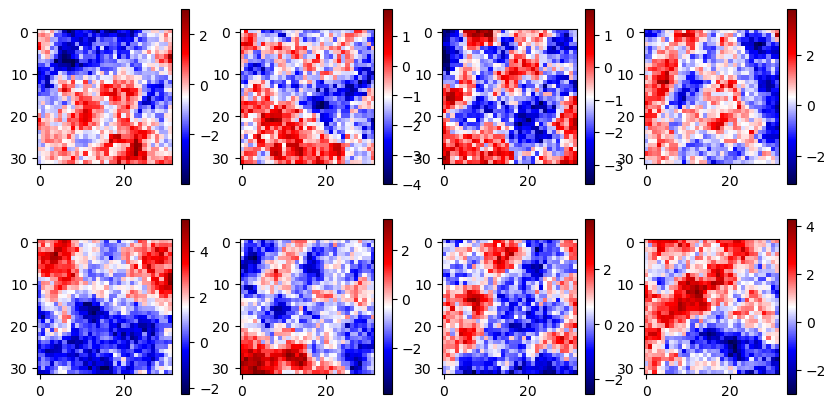

In [5]:
sim = SimulatorBlob(Npix = NPIX, bounds = bounds, sigma = 0.3)
plt.figure(figsize = (10, 5))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    sample = sim.sample()
    t = sample['zn']
    plt.imshow(t, cmap = 'seismic')
    plt.colorbar()

In [6]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, Npix = NPIX):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-2, lrs_factor=0.3, lrs_patience=3)
        self.num_params = Npix**2
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive(Npix**2, "mu")
        self.Npix = Npix

    def forward(self, A, B):
        x = A["z"].view(-1, self.Npix**2)
        f = x + torch.randn_like(x)*0.01
        result = self.lre(f, A['z'].view(-1, self.Npix**2), B['z'].view(-1, self.Npix**2))
        return result

In [7]:
class Network2(swyft.SwyftModule):
    def __init__(self, lr=1e-3, Npix = NPIX):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=3)
        self.num_params = Npix**2
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X(Npix**2, "mu", minstd = 1e-3, momentum = 0.1)
        self.Npix = Npix

    def forward(self, A, B):
        xA = A["zn"]
#        xA[:,:,16:] = 0
        fA = xA.view(-1, self.Npix**2)
        xB = B["zn"]
#        xB[:,:,16:] = 0
        fB = xB.view(-1, self.Npix**2)
        zB = B['z'].view(-1, self.Npix*self.Npix)
        result = self.lre(fA, fB, zB)
        return result

In [8]:
def next_round(sample0, bounds = None, Nsims = 1024):
    sim = SimulatorBlob(bounds = bounds, Npix = NPIX, sigma = .01)
    samples = sim.sample(Nsims)
    dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 256)
    trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 10, precision = 32)
    network = Network2(Npix = NPIX)
    trainer.fit(network, dl)
#    Cov = sim.Cov.double().cuda()
#    network.cuda()
#    f = torch.tensor(sample0['z']).view(-1, sim.Npix**2).cuda()[0]
#    draws = network.lre.get_post_samples(8192, f, prior_cov = Cov*1, gamma = 0.2).view(-1, sim.Npix, sim.Npix).cpu()
    return sim, network#, draws

In [795]:
bounds = None
sample0 = dict(z=z0)
Nsims = 2048
sim, network = next_round(sample0, bounds = bounds, Nsims = Nsims)

  0%|          | 0/2048 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


AttributeError: module 'swyft' has no attribute 'LogRatioEstimator_Gaussian_Autoregressive_X'

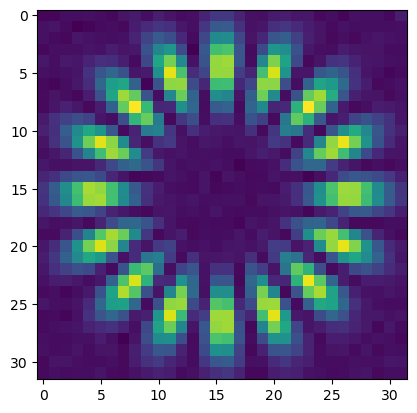

In [744]:
x = z0.view(-1)
best = network.lre.get_MAP(x, sim.Cov)
plt.imshow(best.detach().view(32, 32))

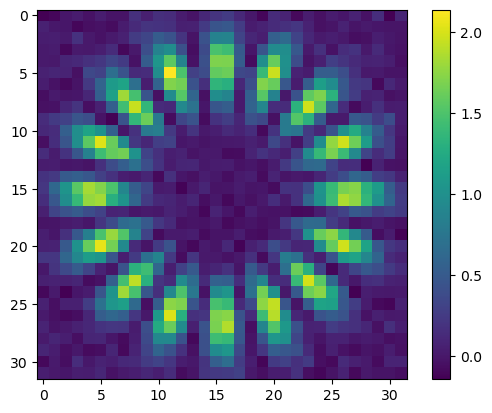

In [792]:
x = z0.view(-1)
draws = network.lre.get_post_samples(10, x, sim.Cov, gamma = 1)
plt.imshow(draws[0].detach().view(32, 32))
plt.colorbar()

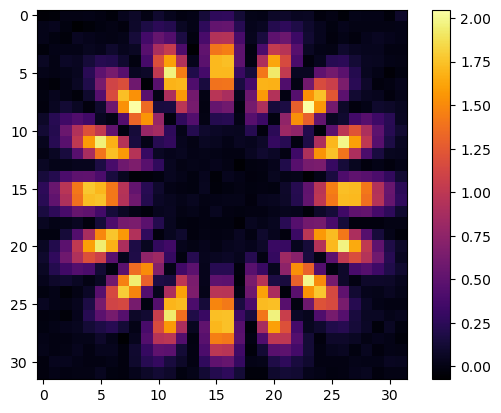

In [739]:
Phi = network.lre.Phi
L = network.lre.L
cov = network.lre.cl2.cov
xm, lm, zm = network.lre.cl2.mean.T
inv_cov = torch.linalg.inv(cov)  # x, Lx, phi z
inv_cov_sub = torch.linalg.inv(cov[:,1:,1:])  # x, Lx, phi z
D = inv_cov.clone()
D[:,1:,1:] -= inv_cov_sub

quadratic = torch.matmul(torch.matmul(Phi.T, torch.diag(D[:,2,2])), Phi)

x = z0.view(-1)
linear = torch.matmul(Phi.T,
                - torch.matmul(torch.diag(D[:,2,0]), x-xm) 
                - torch.matmul(torch.diag(D[:,2,1]), torch.matmul(L, x)-lm)
                + torch.matmul(torch.diag(D[:,2,2]), zm))

GAMMA = 1.0

full_cov = torch.linalg.inv(quadratic*GAMMA + torch.linalg.inv(sim.Cov))

best = torch.matmul(full_cov, linear*GAMMA)

plt.imshow(best.view(NPIX, NPIX).detach(), cmap = 'inferno')
plt.colorbar()

In [740]:
LL = torch.linalg.cholesky(full_cov)

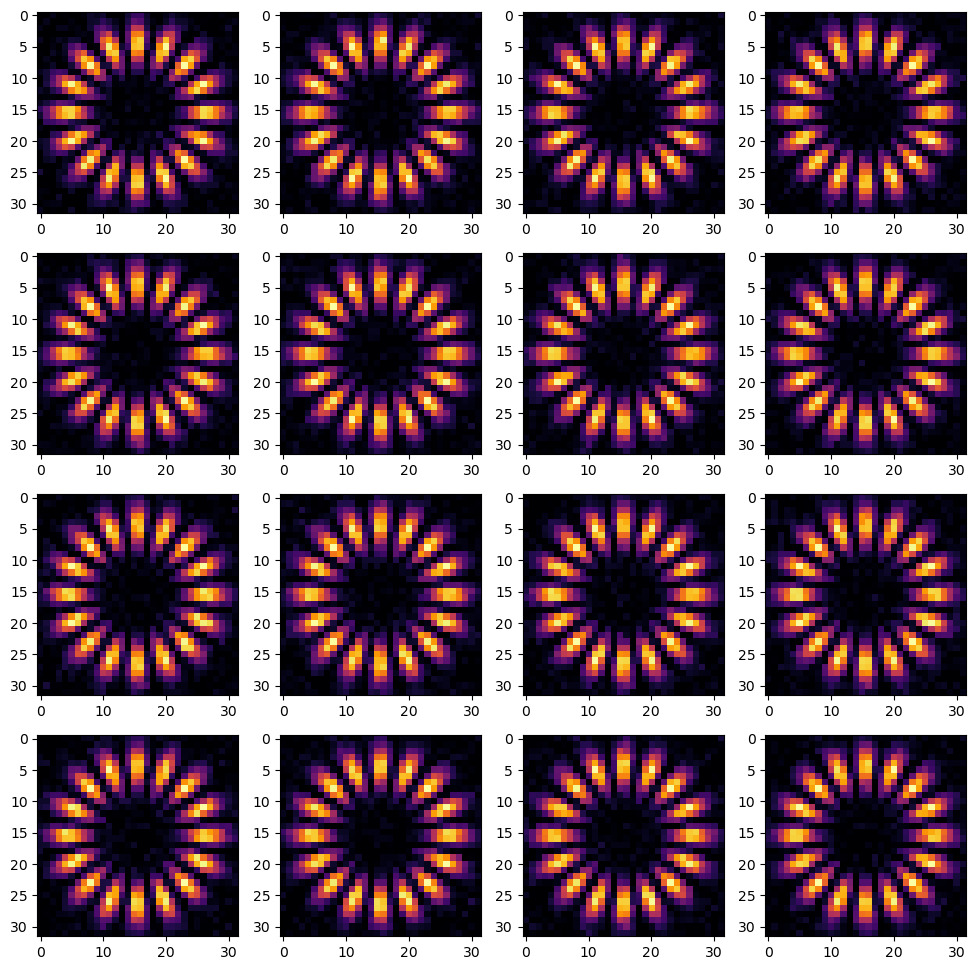

In [741]:
dist = torch.distributions.MultivariateNormal(best.double(), scale_tril = LL.double())
draw = dist.sample(torch.Size([16])).view(-1, NPIX, NPIX)

plt.figure(figsize = (12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(draw[i], cmap = 'inferno', vmin = 0, vmax = 2)

In [608]:
sim.Cov.shape

torch.Size([1024, 1024])

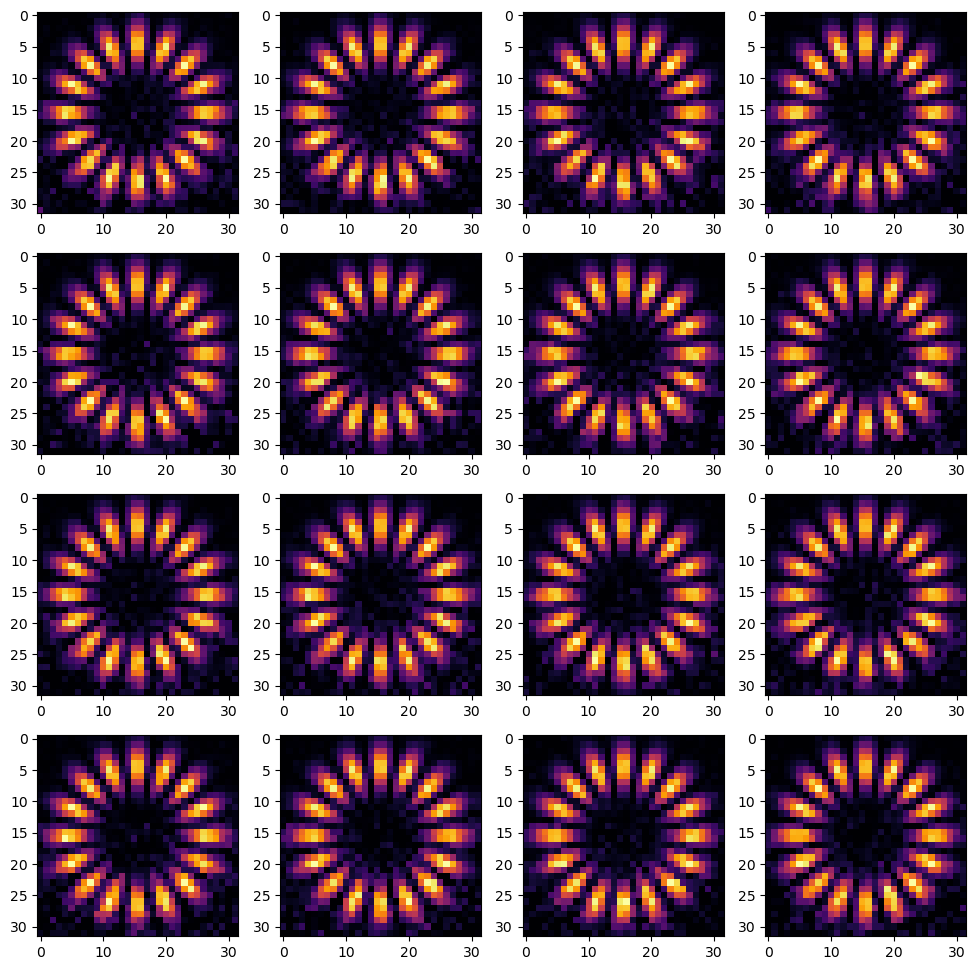

In [9]:
plt.figure(figsize = (12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(bounds[i], cmap = 'inferno', vmin = 0, vmax = 2)